## Assignment 1 - Mnist with a simple (one hidden layer) Neural Net

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

device = torch.device("cpu") #Use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #If nvidea GPU is available use GPU
device

device(type='cuda', index=0)

Creating the nn.module for a neural network with two layers. 

In [2]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    self.D_out = D_out

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    # flatten the tensor
    x = x.view(x.size(0), -1)
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return torch.nn.functional.log_softmax(y_pred, dim=1)

Setup vars that impact the time and effectivness of the training process.

In [3]:
batch_size_train = 64*10
batch_size_test = 1000
learning_rate = 1e-3
n_epoch = 50

Loading the mnist-dataset, pictures of handwritten numbers.

In [4]:
train_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                             ]))

#train_loader = torch.utils.data.DataLoader(
#  train_mnist,
#  batch_size=batch_size_train, shuffle=True)

Precomputing the *torchvision.transforms* and loading the **complete** dataset on the GPU. This is not nessesary and in some cases a stupid idea, but in this case it causes a huge speedup, so not doing this is an enormous waste of time.

In [5]:
train_data = []
train_labels = []
for img, label in train_mnist:
    train_data.append(img)
    train_labels.append(label)

train_data = torch.stack(train_data)
train_labels = torch.tensor(train_labels)

train_data = train_data.to(device)
train_labels = train_labels.to(device)

train_loader = torch.utils.data.DataLoader(
  torch.utils.data.TensorDataset(train_data, train_labels),
  batch_size=batch_size_train, shuffle=True)

Loading the test-dataset. Here we don't precompute and don't transfer the data to the GPU because we will only use this data a few times. The train data will be used in multiple epochs so we get much more use out of the prepared data.

In [6]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Setting up the vars for the network. 

The hidden layer is 100 per assignment. 

The  output needs to be 10 for 0-9.

And finally the input is 784=28*28 for the gray-value each pixel of a 28x28 image.

In [7]:
D_in, H, D_out = 784, 100, 10

In [8]:
model = TwoLayerNet(D_in, H, D_out)
model = model.to(device)
train_losses = []

Training the model using nn.functional.nll_loss as loss and optim.SGD as optimizer 

Time 
cpu(i5-9400F): 53.1s

gpu(4060 Ti): 39.1s

In [9]:
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model.train()
for i in range(n_epoch):
  for x, y in train_loader:
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = loss_fn(y_pred, y)
    print(loss.item())
    train_losses.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

2.3378982543945312
2.337216854095459
2.3386387825012207
2.3308470249176025
2.350083827972412
2.3209338188171387
2.343855619430542
2.322603940963745
2.3013739585876465
2.309724807739258
2.3111648559570312
2.295022487640381
2.321704149246216
2.324748992919922
2.2902233600616455
2.2895655632019043
2.2990708351135254
2.301474094390869
2.2941946983337402
2.2820992469787598
2.2885501384735107
2.301378011703491
2.3120148181915283
2.301844358444214
2.287822961807251
2.280992031097412
2.267259120941162
2.2877233028411865
2.2831850051879883
2.272981882095337
2.2841601371765137
2.268254518508911
2.264697313308716
2.26515531539917
2.262544631958008
2.2758357524871826
2.2726285457611084
2.263903856277466
2.264698028564453
2.255236864089966
2.2737672328948975
2.2598698139190674
2.268022298812866
2.232060670852661
2.2538349628448486
2.2435169219970703
2.2546610832214355
2.2460126876831055
2.2374844551086426
2.237821340560913
2.2436904907226562
2.2418832778930664
2.244248390197754
2.24342679977417
2.2

Text(0, 0.5, 'negative log likelihood loss')

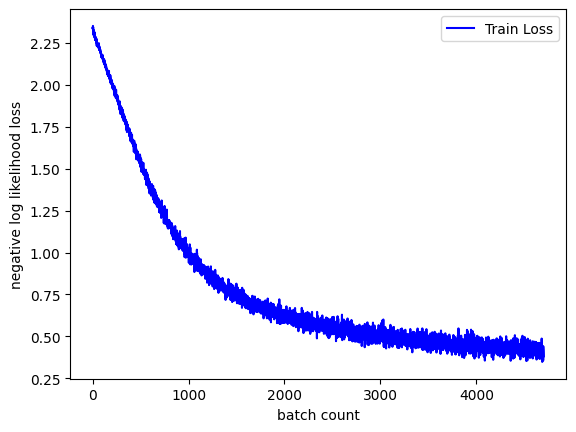

In [10]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('batch count')
plt.ylabel('negative log likelihood loss')

In [11]:
model.eval()
model.cpu()
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    output = model(data)
    test_loss += torch.nn.functional.nll_loss(output, target, size_average=False).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_loader.dataset)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

c:\Users\Fabian\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3971, Accuracy: 8935/10000 (89%)

